In [1]:
import numpy as np

from devito.logger import info
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, PointSource, Receiver

from opescibench import LinePlotter

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:

class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking,
    all is the same as a model except the critical dt
    made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value from the CFL condition."""
        # For a fixed time order this number goes down as the space order increases.
        #
        # The CFL condtion is then given by
        # dt <= coeff * h / (max(velocity))
        coeff = 0.38 if len(self.shape) == 3 else 0.42
        return .1

# Manufacture solution

https://arxiv.org/pdf/1702.01383.pdf

x/sqrt(x)*exp(-(pi f0) (r(x,z) - at)^2) - exp(-(pi f0) (r(x,z) - a2 t)^2)

# Verification

We compute the error between the numerical and analytical solutions for varying spatial discretization order and grid spacing. We also compare the time to solution to the erro for these parameters.

In [ ]:
from sympy import Eq, solve, cos, sin, sqrt, diff, exp
from devito import clear_cache, Operator, TimeFunction, Function
from devito.logger import set_log_level
sizes = ((401 , 2.0), (251, 3.2), (201, 4.0)) #, (101, 8.0), (51, 16.0))
orders = [2, 4, 6, 8 ,10]

errorl2 = np.zeros((len(sizes), len(orders)))
times = np.zeros((len(sizes), len(orders)))

set_log_level("ERROR")

cs = -1

for nn, h in sizes:
    cs += 1
    co = -1
    for spc in orders:
        co += 1
        clear_cache()
        nt = 300
        modelloc = ModelBench(vp=1., origin=(0., 0.), spacing=(h, h), shape=(nn, nn), nbpml=spc,
                              dtype = np.float64)
        dt = modelloc.critical_dt
        # Create symbols for forward wavefield, source and receivers
        u = TimeFunction(name='u', grid=modelloc.grid, save=False,
                         time_order=2, space_order=spc)

        anlytic = Function(name='anlytic', grid=modelloc.grid, space_order=spc)
        s = modelloc.grid.stepping_dim.spacing
        x, y = modelloc.grid.dimensions
        sol = (sin(4.0* np.pi *(x-spc)/nn) * sin(4.0* np.pi *(y-spc)/nn) * 
               sin(2.0* np.pi * modelloc.grid.time_dim*dt/nt))
        source_term = (diff(sol, modelloc.grid.time_dim, 2) -
               diff(sol, modelloc.grid.dimensions[0], 2) -
               diff(sol, modelloc.grid.dimensions[1], 2))
    

        stencil = [Eq(u.forward, 2.0 * u - u.backward +  dt**2 * (u.laplace + source_term))]
        analytical = [Eq(anlytic, sol.subs({modelloc.grid.time_dim : nt}))]
        init_0 = [Eq(u.indexed[0, modelloc.grid.dimensions[0], modelloc.grid.dimensions[1]], source_term.subs({modelloc.grid.time_dim : 0}))]
        init_1 = [Eq(u.indexed[1, modelloc.grid.dimensions[0], modelloc.grid.dimensions[1]], source_term.subs({modelloc.grid.time_dim : 1}))]

        op = Operator(init_0 + init_1 + stencil + analytical, dse='noop', dle='noop')
        
        summary = op.apply(t_e=nt)
        
        errorl2[cs, co] = h*np.linalg.norm(anlytic.data[2*spc:-2*spc, 2*spc:-2*spc]/np.linalg.norm(anlytic.data[2*spc:-2*spc, 2*spc:-2*spc], 2) - 
                                         u.data[(nt)%3, 2*spc:-2*spc, 2*spc:-2*spc]/np.linalg.norm(u.data[(nt)%3, 2*spc:-2*spc, 2*spc:-2*spc], 2))
        times[cs, co] = summary.timings['main']
        
        print("starting space order %s with (%s, %s) grid points the error is %s" % (spc, nn, nn, errorl2[cs, co]))
        
        
        

In [ ]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')

with LinePlotter(figname='MyPrettyPicture.pdf', plotdir='./',  xlabel='error') as plot:
    for i in range(0, len(orders)):
        plot.add_line(list(errorl2[:, i]), list(times[:, i]), label=('order %s' % orders[i]),
                      annotations=[('dx = %s m' % (sc)) for _, sc in sizes][::-1], style=stylel[i])

plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture.pdf", width=600, height=600)

In [ ]:
print(times)

In [ ]:
print(errorl2)

In [ ]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')
style2 = ('--k', '--b', '--r', '--g', '--c')

with LinePlotter(figname='MyPrettyPicture3.pdf', plotdir='./',  xlabel='Grid size', ylabel = 'L2 error') as plot:
    for i in range(0, len(orders)):
        theory = [k**(orders[i]) for k in [2, 4, 6]][::-1]
        theory = [errorl2[-1,i]*th/theory[0] for th in theory]
        plot.add_line([sc for _, sc in sizes][::-1], list(errorl2[::-1, i]), label=('order %s' % orders[i]),
                      annotations=[('dx = %s m' % (sc)) for _, sc in sizes][::-1], style=stylel[i])
        plot.add_line([sc for _, sc in sizes][::-1], list(theory), style=style2[i])
plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture3.pdf", width=600, height=600)

In [10]:
h = 4.0
nn = 201
spc = 2
nt = 100
from devito import clear_cache, TimeFunction, Operator, Function
from devito.logger import set_log_level
from sympy import Eq, solve, cos, sin, sqrt,exp, diff

clear_cache()
set_log_level("DEBUG")

modelloc = ModelBench(vp=1., origin=(0., 0.), spacing=(h, h), shape=(nn, nn), nbpml=spc, dtype=np.float64)
dt = modelloc.critical_dt

# Create symbols for forward wavefield, source and receivers
u = TimeFunction(name='u', grid=modelloc.grid, save=False,
                 time_order=2, space_order=spc)
anlytic = Function(name='anlytic', grid=modelloc.grid, space_order=spc)

s = modelloc.grid.stepping_dim.spacing
x, y = modelloc.grid.dimensions
sol = (sin(10.0* np.pi *(x-spc)/(nn)) * sin(10.0* np.pi *(y-spc)/(nn)) * 
       sin(2.0* np.pi * modelloc.grid.time_dim*s))

source_term = (diff(sol, modelloc.grid.time_dim, 2) -
               diff(sol, modelloc.grid.dimensions[0], 2) -
               diff(sol, modelloc.grid.dimensions[1], 2))

stencil = [Eq(u.forward, 2.0 * u - u.backward + dt**2 * (u.laplace + source_term))]
analytical = [Eq(anlytic, sol.subs({modelloc.grid.time_dim : nt}))]
init_0 = [Eq(u.indexed[0, x, y], sol.subs({modelloc.grid.time_dim : 0}))]
init_1 = [Eq(u.indexed[1, x, y], sol.subs({modelloc.grid.time_dim : 1}))]

op = Operator(init_0 + init_1 + stencil + analytical, dse='noop', dle='noop')

Allocating memory for damp ((205, 205))


In [12]:
print(sol)
print(source_term)

sin(6.28318530717959*time*dt)*sin(0.156298141969641*x - 0.312596283939283)*sin(0.156298141969641*y - 0.312596283939283)
-39.4784176043574*dt**2*sin(6.28318530717959*time*dt)*sin(0.156298141969641*x - 0.312596283939283)*sin(0.156298141969641*y - 0.312596283939283) + 0.0488582183663244*sin(6.28318530717959*time*dt)*sin(0.156298141969641*x - 0.312596283939283)*sin(0.156298141969641*y - 0.312596283939283)


In [14]:
summary = op.apply(t_e=nt, dt=dt)

Section section_0<204,204> with OI=1.24 computed in 0.002 s [0.22 GFlops/s]
Section section_2<205,205> with OI=1.25 computed in 0.001 s [0.30 GFlops/s]
Section main<101,204,204> with OI=2.88 computed in 0.138 s [1.43 GFlops/s, 0.03 GPts/s]


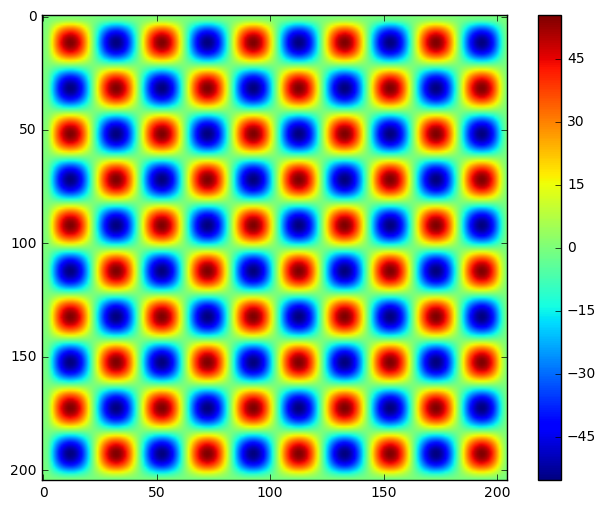

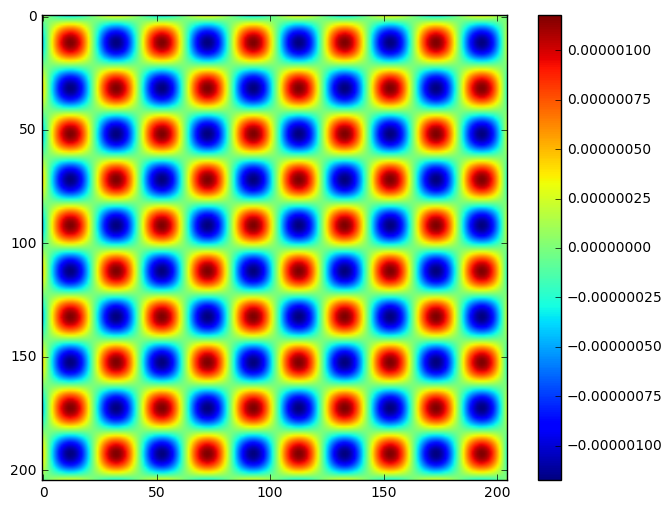

In [15]:
plt.figure()
plt.imshow(u.data[(nt)%3, :, :])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(anlytic.data[:, :])
plt.colorbar()
plt.show()
# plt.figure()
# plt.imshow(u.data[(nt)%3, spc:-spc, spc:-spc] - anlytic.data[spc:-spc, spc:-spc])
# plt.colorbar()
# plt.show()

In [ ]:
# plt.figure()
# plt.imshow(u.data[(nt)%3, 2*spc:-2*spc, 2*spc:-2*spc]/np.max(u.data[(nt)%3, 2*spc:-2*spc, 2*spc:-2*spc]))
# plt.colorbar()
# plt.show()
# plt.figure()
# plt.imshow(anlytic.data[2*spc:-2*spc, 2*spc:-2*spc]/np.max(anlytic.data[2*spc:-2*spc, 2*spc:-2*spc]))
# plt.colorbar()
# plt.show()
# plt.figure()
# plt.imshow(u.data[(nt)%3, 2*spc:-2*spc, 2*spc:-2*spc]/np.max(u.data[(nt)%3, 2*spc:-2*spc, 2*spc:-2*spc]) -
#            anlytic.data[2*spc:-2*spc, 2*spc:-2*spc]/np.max(anlytic.data[2*spc:-2*spc, 2*spc:-2*spc]))
# plt.colorbar()
# plt.show()